In [1]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('date_regresie.csv')

columns = [column for column in df.columns]
df = df[columns]

for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()

df.to_csv('date_regresie', header=False, index=False)
data = df

In [6]:
y = data['Satisfactie']
x1 = data['Salariu']
x2 = data['Ore_lucrate']

with pm.Model() as regression_model:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    beta2 = pm.Normal('beta2', mu=0, sigma=20)
    beta3 = pm.Normal('beta3', mu=0, sigma=10)

    epsilon = pm.HalfNormal('epsilon', sigma=10)
    miu = pm.Deterministic('miu', alpha + beta1 * x1 + beta2 * x2 + beta3 * x1 * x2)

    y_pred = pm.StudentT('y_pred', mu=miu, sigma=epsilon, nu=3, observed=y)
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

print(az.summary(trace, var_names=['alpha', 'beta1', 'beta2', 'beta3', 'epsilon']))

Output()

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha   -2.733  2.617  -7.600    2.172      0.128    0.093     419.0   
beta1    1.268  0.368   0.578    1.972      0.018    0.013     429.0   
beta2    0.126  0.059   0.010    0.232      0.003    0.002     425.0   
beta3   -0.010  0.008  -0.025    0.006      0.000    0.000     432.0   
epsilon  1.100  0.112   0.900    1.323      0.005    0.003     596.0   

         ess_tail  r_hat  
alpha       406.0   1.01  
beta1       378.0   1.01  
beta2       399.0   1.01  
beta3       336.0   1.00  
epsilon     375.0   1.00  


In [8]:
print(az.summary(trace, var_names=['alpha', 'beta1', 'beta2', 'beta3','epsilon']))

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha   -2.733  2.617  -7.600    2.172      0.128    0.093     419.0   
beta1    1.268  0.368   0.578    1.972      0.018    0.013     429.0   
beta2    0.126  0.059   0.010    0.232      0.003    0.002     425.0   
beta3   -0.010  0.008  -0.025    0.006      0.000    0.000     432.0   
epsilon  1.100  0.112   0.900    1.323      0.005    0.003     596.0   

         ess_tail  r_hat  
alpha       406.0   1.01  
beta1       378.0   1.01  
beta2       399.0   1.01  
beta3       336.0   1.00  
epsilon     375.0   1.00  


i) media lui beta3 este foarte aproape de 0, ceea ce însemnă că nu există o relație prea puternică între salariu și orele lucrate

ii) beta1 este parametrul cu ponderea cea mai mare, ceea ce înseamnă că atributul determinat de el (,anume salariul) influențează satisfacția cel mai mult

iii) beta2 (corespunzător orelor lucrate), influențează datele, dar mai puțin decât salariul

array([<Axes: title={'center': 'beta1'}>,
       <Axes: title={'center': 'beta2'}>,
       <Axes: title={'center': 'beta3'}>,
       <Axes: title={'center': 'epsilon'}>], dtype=object)

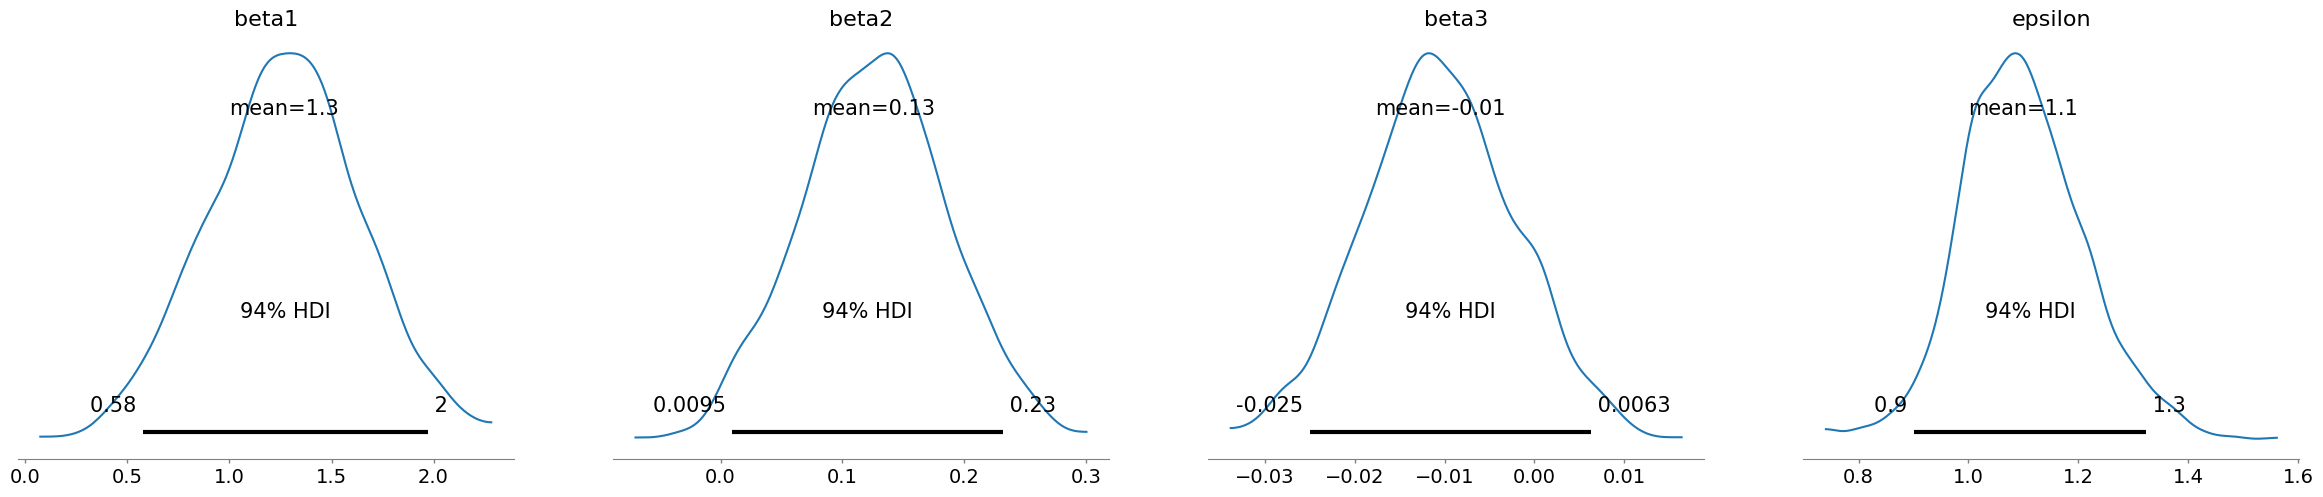

In [9]:
az.plot_posterior(trace, var_names=['beta1', 'beta2', 'beta3', 'epsilon'], hdi_prob=0.94)

In [14]:
df = pd.read_csv('greutati.csv')

columns = [column for column in df.columns]
df = df[columns]

for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()

df.to_csv('date_regresie', header=False, index=False)
data = df

In [21]:
def run_mixture_model(K, weights):
    with pm.Model() as model:

        pi = pm.Dirichlet("pi", a=np.ones(K))

        mu = pm.Normal("mu", mu=np.mean(weights), sigma=np.std(weights), shape=K)

        sigma = pm.HalfNormal("sigma", sigma=np.std(weights), shape=K)

        category = pm.Categorical("category", p=pi, shape=len(weights))

        # the likelihood
        y = pm.Normal("y", mu=mu[category], sigma=sigma[category], observed=weights)

        trace = pm.sample(100, return_inferencedata=True)

    return model, trace

In [22]:
traces = []
models = []
weights = data['Greutate_pește']
for K in [3, 4, 5]:
    print(f"Running model for K={K}")
    model, trace = run_mixture_model(K, weights)
    traces.append(trace)
    models.append(model)

Running model for K=3


Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running model for K=4


Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running model for K=5


Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [24]:
def compute_cluster_probabilities(trace, K, weights):
    posterior_samples = az.extract(trace)
    cluster_assignments = posterior_samples["category"]


    cluster_probs = np.zeros((len(weights), K))

    for i in range(K):
        cluster_probs[:, i] = (cluster_assignments == i).mean(axis=0)  # Mean over posterior samples

    return cluster_probs

K_values = [3, 4, 5]

cluster_probs_dict = {K: compute_cluster_probabilities(traces[i], K, weights) for i, K in enumerate(K_values)}

In [25]:
for K in cluster_probs_dict:
    print(f"Cluster probabilities for K={K}:")
    print(cluster_probs_dict[K])
    print("\n")


Cluster probabilities for K=3:
[[0.265 0.545 0.19 ]
 [0.25  0.53  0.22 ]
 [0.255 0.525 0.22 ]
 [0.26  0.5   0.24 ]
 [0.28  0.5   0.22 ]
 [0.27  0.49  0.24 ]
 [0.26  0.52  0.22 ]
 [0.245 0.535 0.22 ]
 [0.23  0.55  0.22 ]
 [0.245 0.495 0.26 ]
 [0.24  0.495 0.265]
 [0.235 0.49  0.275]
 [0.245 0.525 0.23 ]
 [0.255 0.515 0.23 ]
 [0.245 0.505 0.25 ]
 [0.215 0.575 0.21 ]
 [0.22  0.585 0.195]
 [0.22  0.535 0.245]
 [0.24  0.46  0.3  ]
 [0.235 0.46  0.305]
 [0.225 0.475 0.3  ]
 [0.225 0.46  0.315]
 [0.23  0.44  0.33 ]
 [0.22  0.425 0.355]
 [0.23  0.47  0.3  ]
 [0.225 0.465 0.31 ]
 [0.225 0.495 0.28 ]
 [0.22  0.52  0.26 ]
 [0.245 0.47  0.285]
 [0.23  0.525 0.245]
 [0.255 0.495 0.25 ]
 [0.235 0.46  0.305]
 [0.245 0.475 0.28 ]
 [0.24  0.48  0.28 ]
 [0.26  0.445 0.295]
 [0.255 0.445 0.3  ]
 [0.27  0.42  0.31 ]
 [0.27  0.38  0.35 ]
 [0.28  0.395 0.325]
 [0.26  0.4   0.34 ]
 [0.245 0.375 0.38 ]
 [0.25  0.345 0.405]
 [0.235 0.34  0.425]
 [0.245 0.345 0.41 ]
 [0.245 0.365 0.39 ]
 [0.25  0.365 0.385]
 [0

In [34]:
def compare_models(models_list, traces_list, groups_arr):

    for i in range(len(traces_list)):
        trace = traces_list[i]
        if "log_likelihood" not in trace:
            pm.compute_log_likelihood(trace, model=models_list[i])

    # WAIC
    comp_waic = az.compare(dict(zip([str(group) for group in groups_arr], traces_list)),
                           method='BB-pseudo-BMA', ic='waic', scale='deviance')

    az.plot_compare(comp_waic)
    print(f"Comparing with WAIC:\n{comp_waic}")
    plt.show()

    #  LOO
    comp_loo = az.compare(dict(zip([str(group) for group in groups_arr], traces_list)),
                          method='BB-pseudo-BMA', ic='loo', scale='deviance')

    az.plot_compare(comp_loo)
    print(f"Comparing with LOO:\n{comp_loo}")
    plt.show()



/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Comparing with WAIC:
   rank    elpd_waic     p_waic  elpd_diff    weight         se      dse  \
4     0  1423.509632  50.356884   0.000000  0.511802  17.581981  0.00000   
5     1  1426.580526  60.794960   3.070894  0.282983  17.199104  6.58579   
3     2  1427.617618  46.468298   4.107986  0.205215  17.460364  6.36528   

   warning     scale  
4     True  deviance  
5     True  deviance  
3     True  deviance  


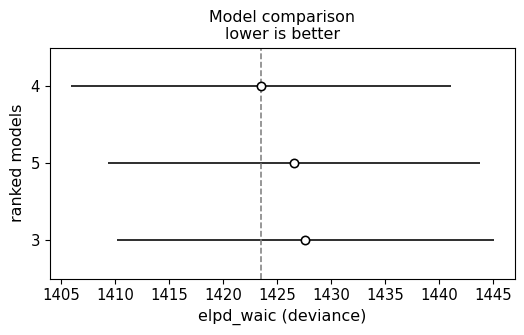

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.57 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.57 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

Comparing with LOO:
   rank     elpd_loo      p_loo  elpd_diff    weight         se        dse  \
3     0  1427.104317  46.211647   0.000000  0.668233  18.052679   0.000000   
4     1  1431.573056  54.388596   4.468739  0.296344  17.955248   8.077567   
5     2  1441.889830  68.449612  14.785513  0.035423  17.567651  10.096724   

   warning     scale  
3     True  deviance  
4     True  deviance  
5     True  deviance  


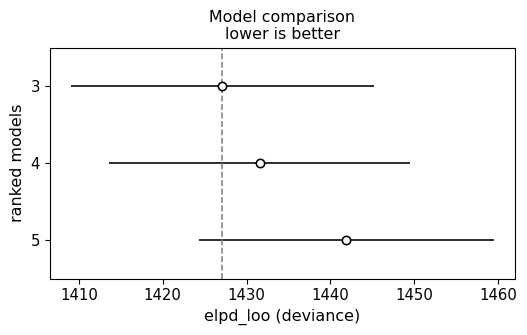

In [36]:
K_values = [3, 4, 5]
compare_models(models, traces, K_values)

cel mai bine se potrivesc 3 subpopulații

In [37]:
def get_mean_weight_for_each_subpopulation(cluster_probs, weights, K):

    mean_weights = np.zeros(K)

    for k in range(K):
        # weighted mean
        weighted_sum = np.sum(cluster_probs[:, k] * weights)
        total_weight = np.sum(cluster_probs[:, k])
        mean_weights[k] = weighted_sum / total_weight

    return mean_weights


In [38]:
K_fixed = 3
cluster_probs = cluster_probs_dict[K_fixed]
mean_weights = get_mean_weight_for_each_subpopulation(cluster_probs, weights, K_fixed)

for i, mean_weight in enumerate(mean_weights):
    print(f"Estimated mean weight for subpopulation {i+1}: {mean_weight:.2f}")

Estimated mean weight for subpopulation 1: 62.35
Estimated mean weight for subpopulation 2: 62.34
Estimated mean weight for subpopulation 3: 62.54


au toate aceeași greutate, deoarece la crearea modelului s-a folosit sigma lui sigma 'determinist':
  sigma = pm.HalfNormal("sigma", sigma=np.std(weights), shape=K)